Reference: https://github.com/deepinsights-analytica/ieee-icpse2021-paper/blob/main/notebooks/A1_DataExploration.ipynb

In [1]:
import warnings, logging, os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf

%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

In [2]:
path = '..'
categories = ['consumption', 'weather', 'profiles']
files = [r"C:\Users\Andrew\Documents\Project\Time Series\Kepco-Search\dataset\Spain_Energy_Consumption/" + '20201015_' + name + '.xlsx' for name in categories]
timezone = 'Europe/Madrid'

In [2]:
def fix_DST(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.resample('H').ffill()
    return data

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

In [4]:
consumptions = pd.read_excel(files[categories.index('consumption')], parse_dates=[0], index_col=0)
consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
consumptions.index.name = 'time'
fix_DST(consumptions)
crop(consumptions)

In [5]:
consumptions

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.039,0.384,0.986,0.706,0.304,0.073,3.262,3.0,0.645,1.279,...,0.431,0.100,0.010,0.258,0.009,0.488,0.810,0.309,0.366,0.290
2019-01-01 01:00:00,0.269,0.051,0.846,2.210,0.673,0.047,3.252,4.0,0.746,0.851,...,0.447,0.025,0.009,0.232,0.009,0.447,0.753,0.381,0.308,0.369
2019-01-01 02:00:00,0.331,0.049,0.970,1.797,0.310,0.058,3.043,4.0,0.678,0.789,...,0.439,0.025,0.009,0.260,0.009,0.508,0.092,0.193,0.137,0.292
2019-01-01 03:00:00,0.093,0.049,0.803,1.010,0.545,0.059,2.960,4.0,0.644,0.637,...,0.913,0.023,0.009,0.252,0.009,0.511,0.032,0.124,0.201,0.358
2019-01-01 04:00:00,0.116,0.050,1.303,0.660,0.410,0.072,3.054,3.0,0.130,0.262,...,1.256,0.024,0.009,0.278,0.009,0.510,0.081,0.081,0.223,0.380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.009,0.052,0.773,0.138,0.579,0.322,3.851,2.0,0.236,0.303,...,0.039,1.308,0.009,1.761,0.011,2.036,0.249,0.223,0.245,0.573
2019-12-31 20:00:00,0.009,0.410,0.738,0.076,0.229,1.810,3.767,1.0,0.053,5.062,...,0.036,0.298,0.027,0.375,0.011,2.022,0.058,0.363,0.354,0.644
2019-12-31 21:00:00,0.010,0.058,0.748,0.072,0.107,1.478,3.342,1.0,0.108,2.140,...,0.261,0.120,0.052,0.463,0.010,1.107,0.011,0.573,0.393,0.635


In [6]:
consumptions.describe()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.283303,0.263868,1.750522,0.275184,0.277605,0.218282,2.393745,4.763017,0.227725,0.602395,...,0.269928,0.170956,0.053764,0.803501,0.169984,0.809818,0.112445,0.238333,0.413233,0.460819
std,0.436013,0.345561,0.781109,0.332088,0.387865,0.248986,1.648356,8.413416,0.310379,0.783770,...,0.363086,0.308614,0.048554,0.824487,0.673361,0.573233,0.112697,0.146475,0.371725,0.127375
min,0.000000,0.041000,0.000000,0.007000,0.008000,0.040000,0.012000,0.000000,0.041000,0.118000,...,0.000000,0.016000,0.008000,0.172000,0.007000,0.160000,0.000000,0.076000,0.079000,0.214000
25%,0.000000,0.062000,1.143750,0.089000,0.091000,0.079000,1.133750,2.000000,0.061000,0.234000,...,0.054000,0.023000,0.010000,0.317750,0.026000,0.422000,0.038000,0.106000,0.149000,0.359000
50%,0.113000,0.094000,1.611000,0.128000,0.105000,0.128000,2.478500,3.000000,0.140000,0.326000,...,0.100000,0.024000,0.053000,0.456000,0.054000,0.592000,0.071000,0.206500,0.295000,0.467000
75%,0.277000,0.387250,2.112250,0.332000,0.266000,0.268000,3.495000,4.000000,0.245000,0.606000,...,0.335250,0.122000,0.084000,1.035250,0.056000,0.976000,0.151000,0.343000,0.473000,0.551000
max,3.067000,3.192000,4.899000,3.547000,3.342000,2.487000,8.994000,107.000000,4.185000,8.691000,...,3.149000,2.115000,1.193000,7.760000,17.114000,4.769000,1.046000,1.040000,2.030000,1.309000


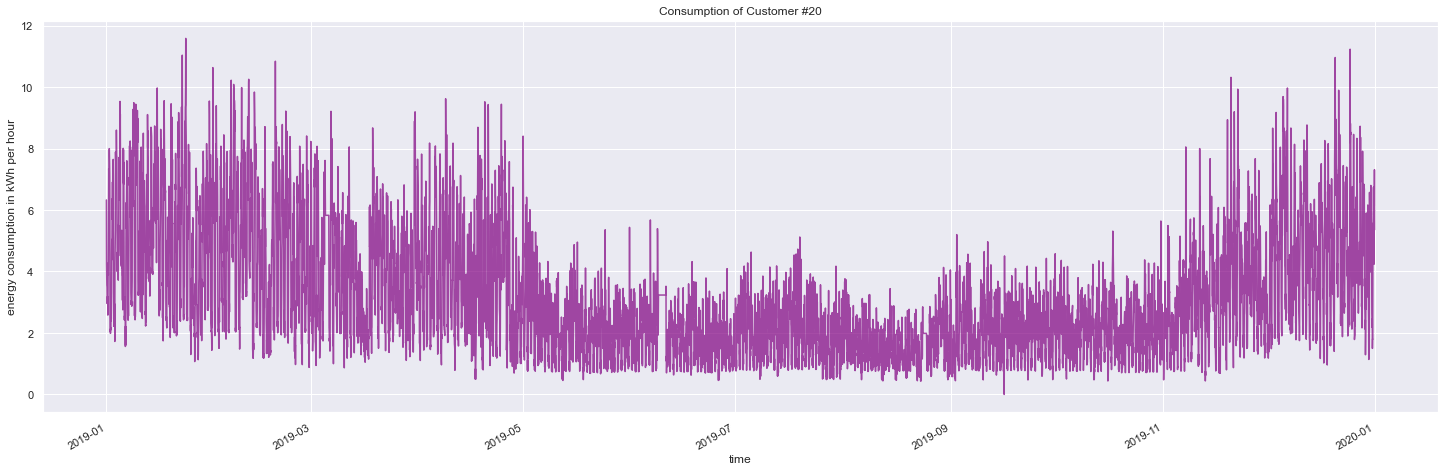

In [16]:
customer = 20
fig, axs = plt.subplots(figsize=(25, 8))
_ = consumptions.loc[:, customer].plot(color='purple', alpha=0.7, ylabel='energy consumption in kWh per hour',
                                 title='Consumption of Customer #' + str(customer))

# Loading Weather Data
Each row in the dataframe contains the weather data (outside temperature of the customer's region) for a certain timestamp within the measurement period of about one year (Jan 01 - Dec 30, 2019). The time series were recorded with an hourly resolution.

In [17]:
weather = pd.read_excel(files[categories.index('weather')], parse_dates=[0], index_col=0)
weather.columns = consumptions.columns
weather.index.name = 'time'
fix_DST(weather)
crop(weather)

weather

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,10.31,10.35,1.65,1.70,11.53,10.76,10.57,0.43,1.66,10.49,...,10.40,9.53,9.94,3.19,3.14,3.20,2.63,1.51,1.51,1.51
2019-01-01 01:00:00,10.34,10.38,1.33,1.37,11.78,10.79,10.61,0.17,1.33,10.73,...,10.65,10.21,10.63,3.70,3.65,3.71,2.08,1.21,1.21,1.21
2019-01-01 02:00:00,10.36,10.40,1.01,1.05,12.03,10.82,10.64,-0.09,1.01,10.98,...,10.90,10.88,11.33,4.22,4.17,4.23,1.53,0.91,0.91,0.91
2019-01-01 03:00:00,10.39,10.43,0.69,0.73,12.28,10.84,10.68,-0.34,0.69,11.23,...,11.14,11.56,12.02,4.74,4.69,4.75,0.99,0.60,0.60,0.60
2019-01-01 04:00:00,10.27,10.31,0.47,0.51,12.13,10.73,10.57,-0.62,0.48,11.06,...,10.97,11.33,11.79,4.47,4.42,4.48,0.76,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,17.99,18.03,14.88,14.94,17.51,18.15,18.08,12.33,14.89,16.91,...,16.84,16.00,16.10,11.62,11.57,11.63,8.99,13.20,13.20,13.20
2019-12-31 20:00:00,17.87,17.91,14.69,14.74,17.32,18.10,18.01,12.45,14.70,16.62,...,16.54,15.84,16.01,11.03,10.98,11.04,8.11,13.01,13.01,13.01
2019-12-31 21:00:00,17.74,17.78,14.50,14.55,17.14,18.05,17.94,12.57,14.50,16.33,...,16.25,15.68,15.93,10.44,10.39,10.45,7.22,12.82,12.82,12.82


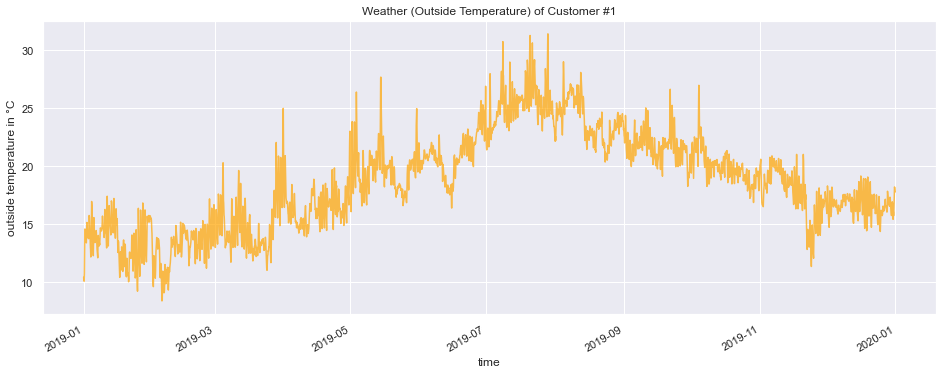

In [19]:
customer = 1
_ = weather.loc[:, customer].plot(color='orange', alpha=0.7, ylabel='outside temperature in °C',
                                 title='Weather (Outside Temperature) of Customer #' + str(customer))

# Loading Holidays
``Since the energy consumption behavior depends on weekly seasonalities like working day or public holiday, a list of all public holidays is needed for feature extraction.
``

In [24]:
holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")
holidays

{datetime.date(2016, 1, 1): 'Año nuevo', datetime.date(2016, 1, 6): 'Epifanía del Señor', datetime.date(2016, 3, 24): 'Jueves Santo', datetime.date(2016, 3, 25): 'Viernes Santo', datetime.date(2016, 5, 2): 'Día de Comunidad de Madrid, Día del Trabajador (Trasladado)', datetime.date(2016, 8, 15): 'Asunción de la Virgen', datetime.date(2016, 10, 12): 'Día de la Hispanidad', datetime.date(2016, 11, 1): 'Todos los Santos', datetime.date(2016, 12, 6): 'Día de la Constitución Española', datetime.date(2016, 12, 8): 'La Inmaculada Concepción', datetime.date(2016, 12, 26): 'Navidad (Trasladado)', datetime.date(2017, 1, 2): 'Año nuevo (Trasladado)', datetime.date(2017, 1, 6): 'Epifanía del Señor', datetime.date(2017, 4, 13): 'Jueves Santo', datetime.date(2017, 4, 14): 'Viernes Santo', datetime.date(2017, 5, 1): 'Día del Trabajador', datetime.date(2017, 8, 15): 'Asunción de la Virgen', datetime.date(2017, 10, 12): 'Día de la Hispanidad', datetime.date(2017, 11, 1): 'Todos los Santos', datetime.da

In [1]:
from utils import SpainDataLoader
dataloader = SpainDataLoader(data_path=r"C:\Users\Andrew\Documents\Project\Time Series\Kepco-Search\dataset\Spain_Energy_Consumption")

C:\Users\Andrew\Documents\Project\Time Series\TSDatasets\utils.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(pd.DataFrame(x.tail(1), index=x.tail(1).index + pd.Timedelta(days=1)))


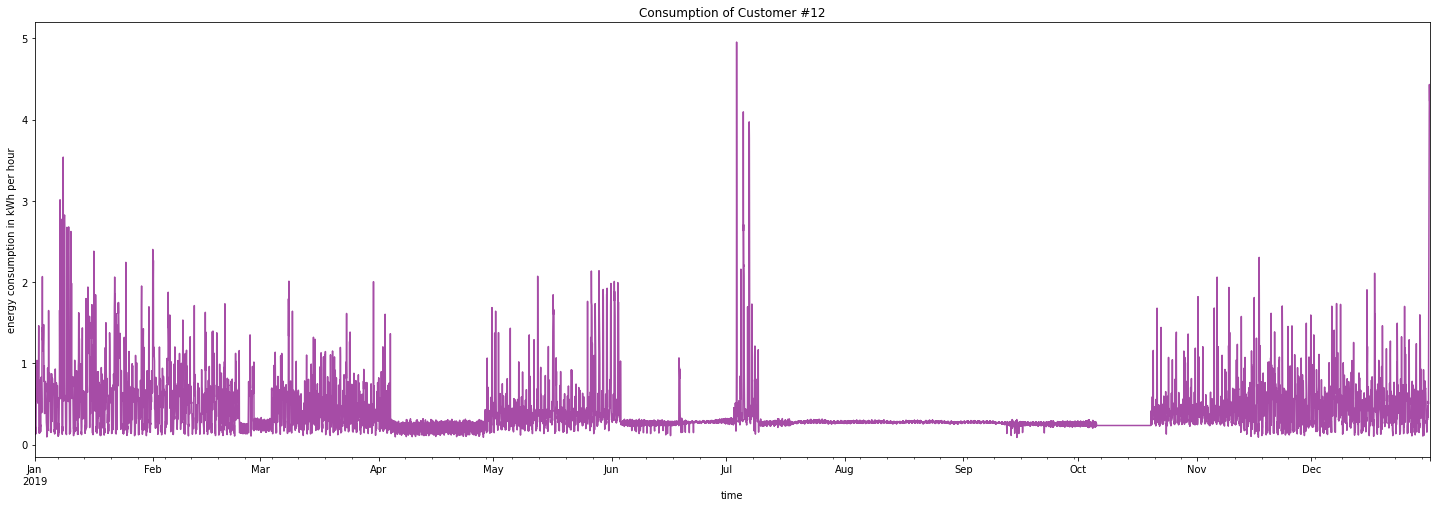

In [2]:
dataloader.plot_sequence(12)

# Save the univariate into the csv file


In [5]:
from utils import SpainDataLoader
dataloader = SpainDataLoader(data_path=r"C:\Users\Andrew\Documents\Project\Time Series\Kepco-Search\dataset\Spain_Energy_Consumption")
import numpy as np

data = dataloader.consumptions.loc[:, 20]

np.savetxt("spain_ec_20.csv",  data, delimiter=",")
# check
data_loaded = np.loadtxt( 'spain_ec_20.csv', dtype=int)
print(data_loaded)

C:\Users\Andrew\Documents\Project\Time Series\TSDatasets\utils.py:388: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(pd.DataFrame(x.tail(1), index=x.tail(1).index + pd.Timedelta(days=1)))


NameError: name 'np' is not defined

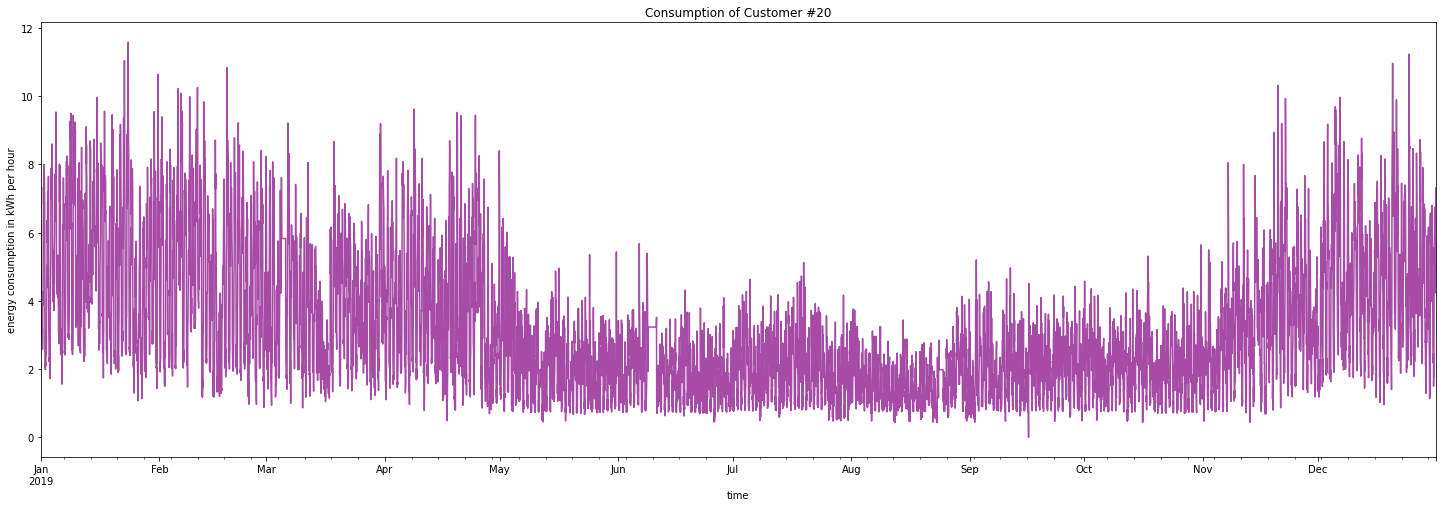

In [9]:
dataloader.plot_sequence(20)

In [4]:
len(dataloader.consumptions.loc[:, 20])

8760

In [2]:
from utils import TSF
input_width = 12
label_width = 3
tsf = TSF(dataloader.consumptions.loc[:, 20], batch_size=32, shift=1, shuffle=False, input_width=input_width,
          label_width=label_width)

Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)


In [1]:
#Thu nghiem xam xi'
input_width = 12
label_width = 3
import tensorflow as tf
import numpy as np
from tcn import TCN, tcn_full_summary
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# model = Sequential([
#     TCN(input_shape=(input_width, 1),
#             kernel_size=2,
#             return_sequences=True,
#             use_skip_connections=False,
#             use_batch_norm=False,
#             use_weight_norm=False,
#             use_layer_norm=False
#             ),
#     v
#     # tf.keras.layers.LSTM(32, return_sequences=True),
#     Dense(units=1, activation='linear'),
#     # Dense(units=3, activation='linear')
# ])
x1 = tf.keras.layers.Input(shape=(input_width, 1))
x2 = TCN(input_shape=(input_width, 1),
            kernel_size=2,
            return_sequences=True,
            use_skip_connections=False,
            use_batch_norm=False,
            use_weight_norm=False,
            use_layer_norm=False)(x1)
x_fuck = x2[:, -3:, :]
x3 = Dense(1)(x_fuck)
model = tf.keras.Model(inputs=x1, outputs = x3)

fake_data = np.random.rand(2, 12, 1)
model.compile('adam', 'mae', metrics=['accuracy'])
tcn_full_summary(model)

# pred = model.predict(fake_data)
# print(model.summary())
# print(pred)

AttributeError: 'Functional' object has no attribute '_layers'

In [4]:
tf.__version__

'2.7.0'

In [62]:
#Thu nghiem xam xi'2
fake_data = np.random.rand(32, 12, 1)
y_pred = tf.convert_to_tensor(model.predict(fake_data))
print(y_pred.shape)
y_true = tf.cast(np.random.rand(32, 3, 1), y_pred.dtype)
print(y_true.shape)
rec = tf.keras.backend.mean(tf.abs(y_pred - y_true), axis=-1)

(32, 3, 1)
(32, 3, 1)


In [63]:
print(rec)
kiki = np.abs(y_pred-y_true.numpy())
print(kiki.shape)

tf.Tensor(
[[6.081368  4.2845526 4.675961 ]
 [5.6397367 5.7703123 5.8355646]
 [5.7941484 5.9469852 5.6332517]
 [7.229356  7.2100096 5.412915 ]
 [6.8313036 6.5253034 5.8940477]
 [5.022589  4.536161  5.747799 ]
 [4.836461  5.982051  5.59789  ]
 [7.3993397 5.667731  5.999963 ]
 [5.907475  8.972905  6.2121377]
 [5.9141464 6.720204  4.9507937]
 [5.653638  6.0195823 7.152029 ]
 [7.0394487 5.5570145 6.615298 ]
 [7.0216465 6.1804714 5.7944016]
 [4.9548936 6.345005  6.397383 ]
 [7.1043143 5.182886  6.8461175]
 [5.029091  4.517824  5.987264 ]
 [4.220092  4.758503  6.686286 ]
 [6.0156035 6.317366  5.555382 ]
 [6.77317   6.6031823 5.7384562]
 [6.079948  4.5925145 5.7344623]
 [6.6922617 6.6934714 6.244014 ]
 [5.6531386 6.153359  5.7976637]
 [5.868656  5.2905393 4.2756104]
 [5.667724  7.792925  5.0456805]
 [5.0926256 4.0276794 4.5063653]
 [6.437498  7.5201964 6.89812  ]
 [7.745581  6.1468267 4.8971252]
 [4.734404  5.624208  4.624231 ]
 [7.8767214 6.2342057 4.8370166]
 [5.77876   5.383029  5.186173 ]

In [65]:
import tensorflow as tf
from tcn import TCN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# model = Sequential([
#     TCN(input_shape=(input_width, 1),
#         kernel_size=2,
#         use_skip_connections=False,
#         use_batch_norm=False,
#         use_weight_norm=False,
#         use_layer_norm=False
#         ),
#     Dense(units=1, activation='linear')
# ])

x1 = tf.keras.layers.Input(shape=(input_width, 1))
x2 = TCN(input_shape=(input_width, 1),
            kernel_size=2,
            return_sequences=True,
            use_skip_connections=False,
            use_batch_norm=False,
            use_weight_norm=False,
            use_layer_norm=False)(x1)
x_fuck = x2[:, -3:, :]
x3 = Dense(1, activation='linear')(x_fuck)
model = tf.keras.Model(inputs=x1, outputs = x3)

model.summary()
model.compile('adam', 'mae')

checkpoint_path = "Spain/cp.ckpt"

print('Train...')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

history = model.fit(tsf.train,
                    validation_data=tsf.val,
                    epochs=100,
                    # callbacks=[checkpoint],
                    verbose=2,
                    use_multiprocessing=True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 tcn_12 (TCN)                (None, 12, 64)            91136     
                                                                 
 tf.__operators__.getitem_3   (None, 3, 64)            0         
 (SlicingOpLambda)                                               
                                                                 
 dense_16 (Dense)            (None, 3, 1)              65        
                                                                 
Total params: 91,201
Trainable params: 91,201
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/100
192/192 - 4s - loss: 0.9054 - val_loss: 0.9827 - 4s/epoch - 21ms/step
Epoch 2/100
192/192 - 3s - los

In [ ]:
tsf.raw_data.ndim

In [9]:
pred = model.predict(tsf.test)
pred

array([[-0.4351173 ],
       [-0.9953194 ],
       [-0.8136998 ],
       ...,
       [-0.79378235],
       [-0.8543517 ],
       [-0.72423905]], dtype=float32)

In [25]:
i = 1
example_labels_shape = 32
while example_labels_shape == 32:
    for example_inputs, example_labels in tsf.test.take(i):
        print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
        print(f'Labels shape (batch, time, features): {example_labels.shape}')
        example_labels_shape = example_labels.shape[0]
        # print(example_labels)
    i+=1

Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 3, 1)
Inputs sha

In [27]:
i

56

In [30]:
import tensorflow as tf
from tcn import TCN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [31]:
model = Sequential([
    TCN(input_shape=(input_width, 1),
        kernel_size=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(3, activation='linear')
])

model.summary()
model.compile('adam', 'mae', metrics=['accuracy'])

checkpoint_path = "Spain/cp.ckpt"

print('Train...')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

history = model.fit(tsf.train,
                    validation_data=tsf.val,
                    epochs=100,
                    # callbacks=[checkpoint],
                    verbose=2,
                    use_multiprocessing=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                91136     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 91,201
Trainable params: 91,201
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/100
192/192 - 25s - loss: 0.9217 - val_loss: 0.6108 - 25s/epoch - 132ms/step
Epoch 2/100
192/192 - 4s - loss: 0.4344 - val_loss: 0.5748 - 4s/epoch - 19ms/step
Epoch 3/100
192/192 - 4s - loss: 0.3928 - val_loss: 0.4743 - 4s/epoch - 19ms/step
Epoch 4/100
192/192 - 4s - loss: 0.3718 - val_loss: 1.0023 - 4s/epoch - 19ms/step
Epoch 5/100
192/192 - 4s - loss: 0.3663 - val_loss: 0.5135 - 4s/epoch - 18ms/step
Epoch 6/100
192/192 - 4s -

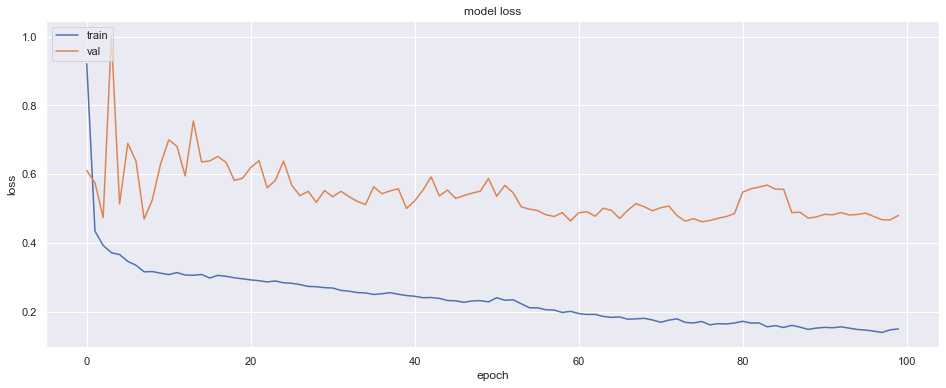

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Check Log normalization

In [12]:
customers, profiles = dataloader.load_metadata()
households = customers[customers['profile'].astype(str).str.contains('hogares')].index.values

consumptions_housholds = dataloader.consumptions.loc[:, households]

consumptions_housholds

,0,1,3,4,5,6,8,9,10,11,...,463,482,483,484,485,487,488,489,494,495
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.039,0.384,0.706,0.304,0.073,3.262,0.645,1.279,0.0,0.349,...,2.511,3.293,0.013,0.002,0.301,0.039,1.670,0.431,0.488,0.810
2019-01-01 01:00:00,0.269,0.051,2.210,0.673,0.047,3.252,0.746,0.851,0.0,0.347,...,2.299,1.365,0.033,0.003,0.287,0.425,1.609,0.447,0.447,0.753
2019-01-01 02:00:00,0.331,0.049,1.797,0.310,0.058,3.043,0.678,0.789,0.0,0.347,...,1.343,0.611,0.011,0.003,0.294,0.134,1.583,0.439,0.508,0.092
2019-01-01 03:00:00,0.093,0.049,1.010,0.545,0.059,2.960,0.644,0.637,0.0,0.349,...,2.703,0.171,0.033,0.003,0.339,0.153,1.492,0.913,0.511,0.032
2019-01-01 04:00:00,0.116,0.050,0.660,0.410,0.072,3.054,0.130,0.262,0.0,0.339,...,0.786,0.499,0.033,0.003,0.288,0.086,2.199,1.256,0.510,0.081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.009,0.052,0.138,0.579,0.322,3.851,0.236,0.303,0.0,0.912,...,0.481,0.932,0.100,0.000,0.330,0.450,0.064,0.039,2.036,0.249
2019-12-31 20:00:00,0.009,0.410,0.076,0.229,1.810,3.767,0.053,5.062,0.0,1.210,...,0.501,0.520,0.200,0.000,0.346,0.808,0.066,0.036,2.022,0.058
2019-12-31 21:00:00,0.010,0.058,0.072,0.107,1.478,3.342,0.108,2.140,0.0,1.047,...,0.657,1.893,0.197,0.000,0.348,1.581,1.353,0.261,1.107,0.011


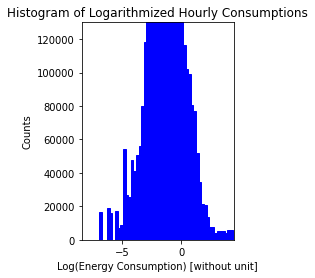

In [13]:
from matplotlib import pyplot as plt
import numpy as np
ax2=plt.subplot(122, title="Histogram of Logarithmized Hourly Consumptions")
ax2.hist(np.log(np.float64((dataloader.consumptions.to_numpy().reshape(-1, 1)).flatten())+1e-5), bins=100,
         facecolor='b', edgecolor='b')
ax2.set_xlim(-8.4,4.4)
ax2.set_ylim(0,130000)
ax2.set_ylabel("Counts")
ax2.set_xlabel("Log(Energy Consumption) [without unit]")
plt.show()